# Predict Startup Success: Data Cleaning

Using Crunchbase's dataset, predict whether a startup will succeed (in this case, be acquired or IPO) or close. Assuming this model will be used by potential investors looking to invest in later stages of startups, look at companies with more than 1 funding round.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas_profiling
%matplotlib inline

## Load the datasets

In [16]:
# Crunchbase 2015 dataset

# One entry per company
companies_df = pd.read_csv('crunchbase-data-master/companies.csv')

additions_df = pd.read_csv('crunchbase-data-master/additions.csv')

# One entry per company acquisition
acquisitions_df = pd.read_csv('crunchbase-data-master/acquisitions.csv')

# One entry per investment
investments_df = pd.read_csv('crunchbase-data-master/investments.csv')

# One entry per round per company
rounds_df = pd.read_csv('crunchbase-data-master/rounds.csv')

## Data Cleaning

### Clean Companies DataFrame

In [495]:
companies_df.shape

(66368, 14)

Drop entries with no first funding date

In [496]:
clean_companies_df = companies_df.dropna(subset=['first_funding_at'])
clean_companies_df.shape

(66344, 14)

**Drop entries with no name**

In [497]:
clean_companies_df = clean_companies_df.dropna(subset=['name'])
clean_companies_df.shape

(66343, 14)

**Format date objects**

Eliminate nonsense dates (1532, for example, was clearly not within the scope of this dataset)

In [498]:
# The first two digits of first_funding_at should be 19 or 20
clean_companies_df = clean_companies_df[
    clean_companies_df.first_funding_at.str.match(r'(19)|(20)')]
clean_companies_df = clean_companies_df[
    clean_companies_df.last_funding_at.str.match(r'(19)|(20)')]
clean_companies_df.shape

(66338, 14)

In [499]:
clean_companies_df.first_funding_at = pd.to_datetime(
    clean_companies_df.loc[:, 'first_funding_at'])
clean_companies_df.last_funding_at = pd.to_datetime(
    clean_companies_df.loc[:, 'last_funding_at'])
clean_companies_df.shape

(66338, 14)

**Convert numerical objects**

In [500]:
# Fill '-' with NaNs to be treated as numeric
clean_companies_df.funding_total_usd.replace('-', np.nan, inplace=True)

In [501]:
# Convert objects to numbers

clean_companies_df.funding_total_usd = pd.to_numeric(
    clean_companies_df.loc[:, 'funding_total_usd'])

clean_companies_df.funding_rounds = pd.to_numeric(
    clean_companies_df.loc[:, 'funding_rounds'])

In [502]:
clean_companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66338 entries, 0 to 66367
Data columns (total 14 columns):
permalink            66338 non-null object
name                 66338 non-null object
homepage_url         61280 non-null object
category_list        63191 non-null object
funding_total_usd    53555 non-null float64
status               66338 non-null object
country_code         59383 non-null object
state_code           57794 non-null object
region               58311 non-null object
city                 58313 non-null object
funding_rounds       66338 non-null int64
founded_at           51122 non-null object
first_funding_at     66338 non-null datetime64[ns]
last_funding_at      66338 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [503]:
clean_companies_df.status.value_counts()

operating    53008
closed        6235
acquired      5548
ipo           1547
Name: status, dtype: int64

In [504]:
# Drop unnecessary columns
clean_companies_df.drop(axis=1, columns=['homepage_url'], inplace=True)

In [505]:
# Save to access easily later
clean_companies_df.to_pickle('data/small_companies_df')

In [520]:
# See how many operating companies were last funded more than 2.5 years ago
clean_companies_df[np.logical_and(
    np.logical_and(clean_companies_df.last_funding_at < pd.to_datetime('2013'),
                   clean_companies_df.first_funding_at > '2005'),
    clean_companies_df.status == 'operating')]

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
3,/organization/0-6-com,0-6.com,Curated Web,2000000.0,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
6,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,762851.0,operating,CAN,BC,Vancouver,Vancouver,2,1997-01-01,2009-09-11,2009-12-21
12,/organization/1-800-dentist,1-800-DENTIST,Health and Wellness,NaN,operating,USA,CA,Los Angeles,Los Angeles,1,1986-01-01,2010-08-19,2010-08-19
13,/organization/1-800-doctors,1-800-DOCTORS,Health and Wellness,1750000.0,operating,USA,NJ,Newark,Iselin,1,1984-01-01,2011-03-02,2011-03-02
17,/organization/10-20-media,10-20 Media,E-Commerce,2050000.0,operating,USA,MD,Baltimore,Woodbine,4,2001-01-01,2009-06-18,2011-12-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66339,/organization/zylie-the-bear,Zylie the Bear,E-Commerce,75000.0,operating,USA,CT,Hartford,Greenwich,1,2009-01-01,2012-06-07,2012-06-07
66346,/organization/zympi,Zympi,Mobile|Networking|Web Hosting,NaN,operating,USA,CA,Ontario - Inland Empire,Redlands,1,2010-09-03,2011-11-22,2011-11-22
66353,/organization/zyngenia,Zyngenia,Biotechnology,25000000.0,operating,USA,MD,"Washington, D.C.",Gaithersburg,1,2008-01-01,2010-09-09,2010-09-09
66359,/organization/zyrra,Zyrra,E-Commerce,1510500.0,operating,USA,MA,Boston,Cambridge,4,NaN,2010-10-21,2012-10-18


In [581]:
# Create dataset containing only companies that failed or succeeded

current_date = clean_companies_df.last_funding_at.max()

nonoperating_companies_df = clean_companies_df[np.logical_or(
    clean_companies_df.status != 'operating',
    np.logical_and(
        np.logical_and(
            clean_companies_df.status == 'operating',
            clean_companies_df.first_funding_at >
            current_year - pd.offsets.DateOffset(years=10)),
        clean_companies_df.last_funding_at < current_year -
        pd.offsets.DateOffset(years=2, months=6)))].reset_index()

In [655]:
nonoperating_companies_df.drop(columns='index', axis=1, inplace=True)

In [656]:
nonoperating_companies_df.shape

(32426, 14)

In [593]:
# Create binary status column where 0 = closed, 1 = aqcquired/IPO
nonoperating_companies_df['status_bool'] = np.nan

# Fill the column
nonoperating_companies_df.loc[np.logical_or(
    nonoperating_companies_df.status == 'closed', nonoperating_companies_df.
    status == 'operating'), 'status_bool'] = 0
nonoperating_companies_df.loc[np.logical_or(
    nonoperating_companies_df.status == 'ipo', nonoperating_companies_df.status
    == 'acquired'), 'status_bool'] = 1

In [594]:
nonoperating_companies_df.status_bool.value_counts()

0.0    25331
1.0     7095
Name: status_bool, dtype: int64

In [605]:
# How many companies don't have funding dollar info?
nonoperating_companies_df.funding_total_usd.isna().sum()

6605

In [657]:
nonoperating_companies_df.sample(5)

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,status_bool
2273,/organization/artabler,Artabler,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,NaN,2015-08-23,2015-08-23,0.0
17838,/organization/mobicanvas,mobicanvas,Mobile|Web Development,50000.0,closed,ZAF,NaN,Cape Town,Stellenbosch,1,2011-01-01,2011-02-01,2011-02-01,0.0
16483,/organization/lyceem,LYCEEM,Travel,NaN,operating,NaN,NaN,NaN,NaN,1,NaN,2011-12-01,2011-12-01,0.0
8531,/organization/efer-io,Eferio,Android|App Stores|Gift Card|Mobile|Mobile Pay...,613677.0,operating,SWE,27,Malmo,Malmö,1,2012-08-01,2012-08-01,2012-08-01,0.0
15779,/organization/lexicon-pharmaceuticals,Lexicon Pharmaceuticals,Biotechnology,244702780.0,ipo,USA,TX,Houston,Houston,4,1995-01-01,2010-03-15,2014-12-12,1.0


### Clean Rounds DataFrame

This dataset contains information about the individual funding rounds for each company

In [452]:
rounds_df.shape

(114949, 12)

Only interested in pre-acquisition / pre-IPO so eliminate rows outside of this

In [17]:
clean_rounds_df = rounds_df[np.logical_and(
    rounds_df.funding_round_type != 'post_ipo_equity',
    rounds_df.funding_round_type != 'post_ipo_debt')]

In [18]:
clean_rounds_df.shape

(114159, 12)

In [19]:
# Convert date column to datetime object
clean_rounds_df.funded_at = pd.to_datetime(clean_rounds_df.loc[:, 'funded_at'])

/anaconda3/envs/metis/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
clean_rounds_df.columns

Index(['company_permalink', 'company_name', 'company_category_list',
       'company_country_code', 'company_state_code', 'company_region',
       'company_city', 'funding_round_permalink', 'funding_round_type',
       'funding_round_code', 'funded_at', 'raised_amount_usd'],
      dtype='object')

In [21]:
clean_rounds_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114159 entries, 0 to 114948
Data columns (total 12 columns):
company_permalink          114159 non-null object
company_name               114158 non-null object
company_category_list      110753 non-null object
company_country_code       105509 non-null object
company_state_code         103252 non-null object
company_region             104028 non-null object
company_city               104031 non-null object
funding_round_permalink    114159 non-null object
funding_round_type         114159 non-null object
funding_round_code         31138 non-null object
funded_at                  114159 non-null datetime64[ns]
raised_amount_usd          94179 non-null float64
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 11.3+ MB


## Features: average time between rounds, average amount raised

In [22]:
# Sort rounds_df by company and date
clean_rounds_df.sort_values(by=['company_name', 'funded_at'],
                            ascending=True,
                            inplace=True)

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
# Create column for time between rounds
clean_rounds_df['time_between_next_round'] = clean_rounds_df.groupby(
    'company_name').funded_at.diff()

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# Calculate average time between rounds and average round amount raised ($)

avg_round_time_amount = clean_rounds_df.groupby('company_name').agg({
    'time_between_next_round':
    pd.Series.mean,
    'raised_amount_usd':
    'mean'
}).rename(
    columns={
        'time_between_next_round': 'avg_time_bw_rounds',
        'raised_amount_usd': 'avg_raise_usd'
    }).reset_index()

In [ ]:
# Merge into main df

nonoperating_companies_df = nonoperating_companies_df.merge(
    avg_round_time_amount, how='left', left_on='name', right_on='company_name')

### Features: time between first and second round

In [ ]:
# Create column in main df
nonoperating_companies_df['time_bw_first_rounds'] = dt.timedelta(0)

for company in clean_rounds_df.company_name.unique():
    if len(clean_rounds_df[clean_rounds_df.company_name ==
                           company].funded_at) > 1:
        nonoperating_companies_df.loc[
            nonoperating_companies_df.name ==
            company, 'time_bw_first_rounds'] = clean_rounds_df[
                clean_rounds_df.company_name == company].funded_at.values[
                    1] - clean_rounds_df[clean_rounds_df.company_name ==
                                         company].funded_at.values[0]

In [239]:
nonoperating_companies_df.to_pickle('data/nonoperating_companies_df.pickle')
nonoperating_companies_df.to_pickle('data/df_before_categories.pickle')

### Features: Categories

Look at the distribution of features amongst the companies to see if there are any that dominate.
Note that for companies with multiple categories they are listed in alphabetical order

In [236]:
with open('data/nonoperating_companies_df.pickle', 'rb') as read_file:
    nonoperating_companies_df = pickle.load(read_file)

In [237]:
# Fill empty category with 'unknown'
nonoperating_companies_df.category_list.fillna('unknown', inplace=True)
# Create column with list of categories
nonoperating_companies_df[
    'cat_list'] = nonoperating_companies_df.category_list.apply(str.split,
                                                                sep='|')

Look at the distribution of categories

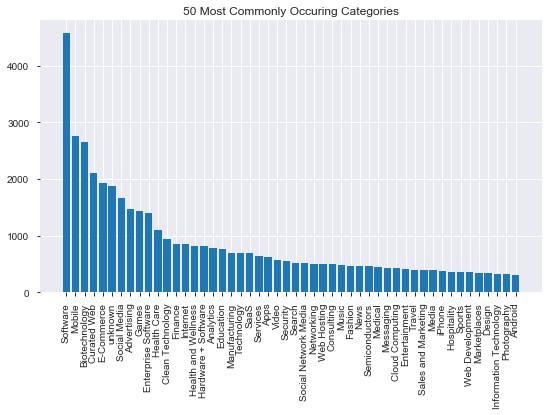

In [238]:
# Create list of category lists
categories = list(nonoperating_companies_df.cat_list)
# Flatten the list
flat_categories = [cat for sublist in categories for cat in sublist]
# Count occurences of each
category_counts = Counter(flat_categories).most_common()
# Look at the distribution
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:50]],
        [x[1] for x in category_counts[0:50]],
        width=0.8)
plt.xticks(rotation=90)
plt.title('50 Most Commonly Occuring Categories')
sns.despine()

In [240]:
# Take the top 25
top_cats = [x[0] for x in category_counts[0:25]]

For each company with a category listed in the top 25 categories, replace its cat_list with that single category

In [241]:
nonoperating_companies_df.cat_list = nonoperating_companies_df.cat_list.map(
    lambda x: list(set(x) & set(top_cats))
    if set(x) & set(top_cats) else ['0_other_cat'])

Look at category distribution again with simplified categories

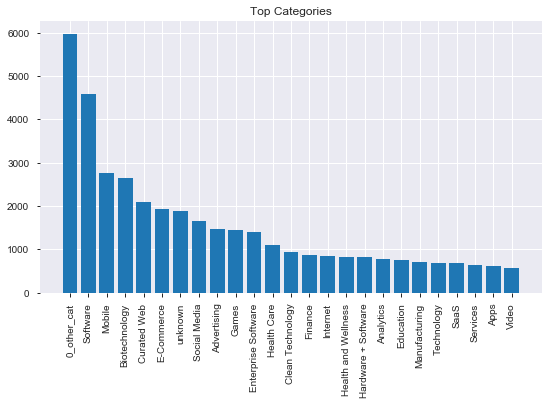

In [242]:
# Create list of category lists
categories = list(nonoperating_companies_df.cat_list)
# Flatten the list
flat_categories = [cat for sublist in categories for cat in sublist]
# Count occurences of each
category_counts = Counter(flat_categories).most_common()
# Look at the distribution
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:25]],
        [x[1] for x in category_counts[0:25]],
        width=0.8)
plt.xticks(rotation=90)
sns.despine()
plt.title('Top Categories')

In [243]:
# This will be used to create dummy variables in the feature matrix
nonoperating_companies_df.cat_list = nonoperating_companies_df.cat_list.apply(
    lambda x: x[0])

In [244]:
nonoperating_companies_df.to_pickle('data/nonoperating_companies_df.pickle')

### Features: Location

Look at the distributions of country, state, region, city

In [245]:
# Country
# Fill empty country with 'unknown'
nonoperating_companies_df.country_code.fillna('unknown', inplace=True)

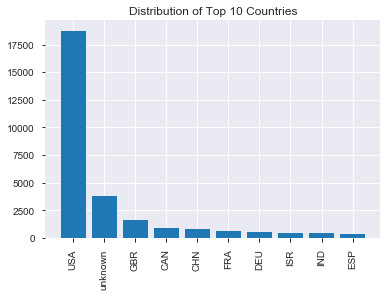

In [246]:
# Look at distribution
country_dist = nonoperating_companies_df.groupby(
    'country_code').size().sort_values(ascending=False)
plt.bar(country_dist[0:10].index, height=country_dist[0:10].values)
plt.xticks(rotation=90)
sns.despine()
plt.title('Distribution of Top 10 Countries')

In [247]:
# Countries with more than 500
top_countries = nonoperating_companies_df.groupby('country_code').size() > 300

# Companies from countries with less than 300 companies go to 'other'
nonoperating_companies_df[
    'country'] = nonoperating_companies_df.country_code.apply(
        lambda x: x if top_countries[x] else '0_other_country')

In [248]:
# Since the large majority are in the USA look at states too
# State
# Fill empty state with 'unknown'
nonoperating_companies_df.state_code.fillna('unknown', inplace=True)

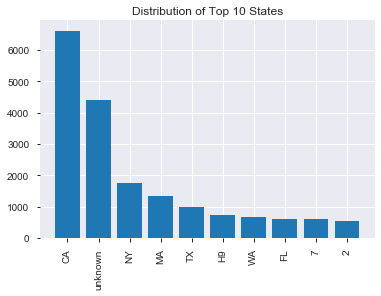

In [249]:
# Look at distribution
state_dist = nonoperating_companies_df.groupby(
    'state_code').size().sort_values(ascending=False)
plt.bar(state_dist[0:10].index, height=state_dist[0:10].values)
plt.xticks(rotation=90)
sns.despine()
plt.title('Distribution of Top 10 States')

In [250]:
# States with more than 500
top_states = nonoperating_companies_df.groupby('state_code').size() > 500

# Companies from states with less than 1000 companies go to 'other'
nonoperating_companies_df[
    'state'] = nonoperating_companies_df.state_code.apply(
        lambda x: x if top_states[x] else '0_other_state')

In [251]:
nonoperating_companies_df.to_pickle('data/nonoperating_companies_df.pickle')

In [252]:
nonoperating_companies_df[nonoperating_companies_df.funding_rounds ==
                          1].status.value_counts()

operating    14661
closed        4794
acquired      2664
ipo            646
Name: status, dtype: int64

### Features: Labeled Rounds (unfinished)
#### Seed Round
Interested to see if having labeled seed rounds and labeled venture rounds vs no seed rounds and unlabeled venture rounds makes a difference in predicting startup success

In [253]:
def seed_code(row):
    """
    Helper Function:
    Replace code field with 'seed' if type field is 'seed'
    """
    if row['funding_round_type'] == 'seed':
        return 'seed'
    return row['funding_round_code']


# Create new column for this
clean_rounds_df['round_code'] = clean_rounds_df.apply(seed_code, axis=1)

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [254]:
# Convert funding date to datetime object
clean_rounds_df.funded_at = pd.to_datetime(clean_rounds_df.loc[:, 'funded_at'])

/anaconda3/envs/metis/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [255]:
# Group by company and round code for companies that segmented their rounds
company_round_groups = clean_rounds_df.groupby(['company_name',
                                                'round_code']).agg({
                                                    'funded_at':
                                                    'max',
                                                    'raised_amount_usd':
                                                    'sum'
                                                })
company_round_groups.reset_index(inplace=True)

In [256]:
# Seed df
seed_df = company_round_groups[company_round_groups.round_code ==
                               'seed'].rename(
                                   columns={
                                       'company_name': 'name',
                                       'round_code': 'seed_bool',
                                       'funded_at': 'seed_date',
                                       'raised_amount_usd': 'seed_amount'
                                   })
seed_df.seed_bool = 1

In [407]:
# Fill in seed_bool column in df for companies with a labeled seed round
df['seed_bool'] = 0
df.loc[df.name.isin(seed_df.name.values), 'seed_bool'] = 1

In [408]:
df.seed_bool.value_counts()

0    22264
1    10162
Name: seed_bool, dtype: int64

In [409]:
nonoperating_companies_df.to_pickle('data/df.pickle')
df.to_pickle('data/df.pickle')

## Fix 0 values (should be nans)

In [260]:
with open('data/nonoperating_companies_df.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [261]:
df.time_bw_first_rounds.replace(to_replace=dt.timedelta(days=0),
                                value=np.nan,
                                inplace=True)

### Cleaning up date info
Set date columns to float values

In [262]:
# Convert timedelta columns to float values for classification models
df['float_avg_time_bw_rounds'] = df.avg_time_bw_rounds.dt.days
df['float_time_bw_first_rounds'] = df.time_bw_first_rounds.dt.days

## Outliers

In [263]:
# Store initial size of dataset
init_size = df.shape

In [264]:
df.describe()

,funding_total_usd,funding_rounds,status_bool,avg_time_bw_rounds,avg_raise_usd,time_bw_first_rounds,seed_bool,float_avg_time_bw_rounds,float_time_bw_first_rounds
count,2.582100e+04,32426.000000,32426.000000,9639,2.561800e+04,9433,32426.0,9639.000000,9433.000000
mean,1.994869e+07,1.568494,0.218806,531 days 20:20:24.842320,9.983271e+06,554 days 05:27:26.771970,0.0,531.707957,554.227393
std,2.436003e+08,1.183781,0.413443,467 days 18:55:03.464741,1.325715e+08,545 days 06:57:20.249379,0.0,467.805388,545.289818
min,2.000000e+00,1.000000,0.000000,0 days 00:00:00,0.000000e+00,1 days 00:00:00,0.0,0.000000,1.000000
25%,3.600000e+05,1.000000,0.000000,250 days 15:00:00,3.000000e+05,226 days 00:00:00,0.0,250.000000,226.000000
50%,2.100000e+06,1.000000,0.000000,421 days 00:00:00,1.600000e+06,425 days 00:00:00,0.0,421.000000,425.000000
75%,1.093134e+07,2.000000,0.000000,671 days 00:00:00,6.705159e+06,722 days 00:00:00,0.0,671.000000,722.000000
max,3.007950e+10,18.000000,1.000000,8643 days 12:00:00,1.760000e+10,16477 days 00:00:00,0.0,8643.000000,16477.000000


The max value for several of the columns is very suspicious for time between rounds and amount ($) raised

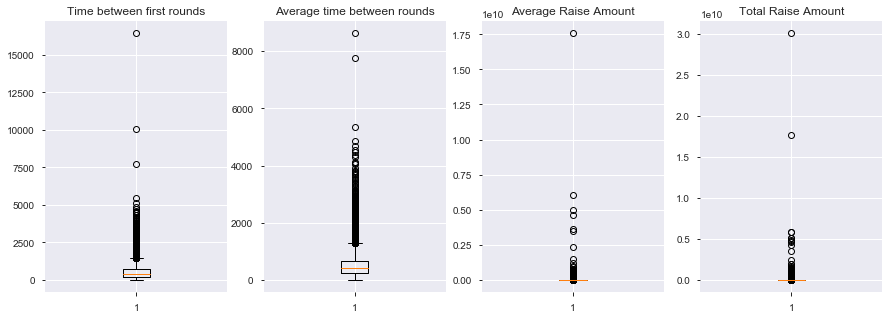

In [265]:
plt.subplots(1, 4, figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.boxplot(
    df.float_time_bw_first_rounds[df.float_time_bw_first_rounds.notnull()])
plt.title('Time between first rounds')
plt.subplot(1, 4, 2)
plt.boxplot(df.float_avg_time_bw_rounds[df.float_avg_time_bw_rounds.notnull()])
plt.title('Average time between rounds')
plt.subplot(1, 4, 3)
plt.boxplot(df.avg_raise_usd[df.avg_raise_usd.notnull()])
plt.title('Average Raise Amount')
plt.subplot(1, 4, 4)
plt.boxplot(df.funding_total_usd[df.funding_total_usd.notnull()])
plt.title('Total Raise Amount')

These are heavily skewed right - can try to cut out some of the outliers

In [266]:
def findOutliers(df, column, lim_scalar=1.5):
    """
    Returns outliers above the max limit for a column in a dataframe
    Adjust outlier cutoff to q75 + 4*iqr to include more data
    ---
    input: DataFrame, column(series),lim_scalar(float)
    output: DataFrame
    """
    q25, q50, q75 = df[column].quantile(q=[0.25, 0.5, 0.75])
    iqr = q75 - q25
    # max limits to be considered an outlier
    max = q75 + lim_scalar * iqr
    # identify the points
    outlier_mask = [True if x > max else False for x in df[column]]
    print(
        '{} outliers found out of {} data points, {:.2f}% of the data'.format(
            sum(outlier_mask), len(df[column]),
            100 * (sum(outlier_mask) / len(df[column]))))
    return outlier_mask

In [267]:
print('Funding total $: ')
fund_total_outlier_mask = pd.Series(
    findOutliers(df, 'funding_total_usd', lim_scalar=3))
print('Average round $: ')
avg_raise_outlier_mask = pd.Series(
    findOutliers(df, 'avg_raise_usd', lim_scalar=3))
print('Time between first rounds: ')
first_time_outlier_mask = pd.Series(
    findOutliers(df, 'float_time_bw_first_rounds', lim_scalar=1.5))
print('Average time between rounds: ')
avg_time_outlier_mask = pd.Series(
    findOutliers(df, 'float_avg_time_bw_rounds', lim_scalar=1.5))

Funding total $: 
2123 outliers found out of 32426 data points, 6.55% of the data
Average round $: 
1498 outliers found out of 32426 data points, 4.62% of the data
Time between first rounds: 
470 outliers found out of 32426 data points, 1.45% of the data
Average time between rounds: 
543 outliers found out of 32426 data points, 1.67% of the data


Lots of overlap on these points. Remove the outliers

In [268]:
# Take out outliers
clean_df1 = df[~fund_total_outlier_mask]
clean_df2 = df[~avg_raise_outlier_mask]
clean_df3 = df[~first_time_outlier_mask]
clean_df4 = df[~avg_time_outlier_mask]

clean_df = clean_df1.merge(clean_df2,
                           left_on=list(df.columns),
                           right_on=list(df.columns),
                           how='inner')
clean_df = clean_df.merge(clean_df3,
                          left_on=list(df.columns),
                          right_on=list(df.columns),
                          how='inner')
clean_df = clean_df.merge(clean_df4,
                          left_on=list(df.columns),
                          right_on=list(df.columns),
                          how='inner')

In [269]:
print('Removed {} outliers, {:.2f}% of the original dataset'.format(
    (init_size[0] - clean_df.shape[0]), 100 *
    ((init_size[0] - clean_df.shape[0]) / (init_size[0] + clean_df.shape[0]))))

Removed 3004 outliers, 4.86% of the original dataset


In [270]:
clean_df.to_pickle('data/clean_df.pickle')

In [271]:
clean_df.describe()

,funding_total_usd,funding_rounds,status_bool,avg_time_bw_rounds,avg_raise_usd,time_bw_first_rounds,seed_bool,float_avg_time_bw_rounds,float_time_bw_first_rounds
count,2.284600e+04,29422.000000,29422.000000,7659,2.273300e+04,7472,29422.0,7659.000000,7472.000000
mean,5.243217e+06,1.438651,0.184182,436 days 14:54:13.151985,3.324563e+06,447 days 02:29:44.582441,0.0,436.501632,447.103988
std,8.040261e+06,0.949003,0.387639,280 days 13:34:11.088023,4.756288e+06,306 days 10:57:54.058703,0.0,280.574769,306.456876
min,2.000000e+00,1.000000,0.000000,0 days 00:00:00,0.000000e+00,1 days 00:00:00,0.0,0.000000,1.000000
25%,2.672890e+05,1.000000,0.000000,228 days 00:00:00,2.500000e+05,211 days 00:00:00,0.0,228.000000,211.000000
50%,1.500000e+06,1.000000,0.000000,389 days 18:00:00,1.167697e+06,389 days 12:00:00,0.0,389.000000,389.500000
75%,6.600000e+06,2.000000,0.000000,599 days 18:00:00,4.523083e+06,633 days 00:00:00,0.0,599.500000,633.000000
max,4.260000e+07,18.000000,1.000000,1302 days 00:00:00,2.580000e+07,1462 days 00:00:00,0.0,1302.000000,1462.000000
